# Análisis de solicitudes a la visa de trabajo de Estados Unidos mediante Aprendizaje Automático

### Jessenia Gonzalez, Iván Peñaranda, Francisco Fujiki y Percy Tippe

## Exploración de los datos

In [0]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [0]:
import multiprocessing
pool = multiprocessing.Pool(processes=8)

In [0]:
visas = pd.read_csv('us_perm_visas.csv')

C:\Users\Francisco\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2698: DtypeWarning: Columns (0,1,2,3,4,5,6,7,10,11,16,17,20,21,22,25,26,27,28,29,30,31,32,33,34,35,36,37,39,40,41,42,43,44,45,47,48,49,50,51,52,53,55,56,57,58,59,60,61,63,64,65,66,68,69,70,71,72,73,74,77,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,100,101,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,153) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


El conjunto de datos está conformado por más de 374000 observaciones y posee 154 variables.

In [0]:
visas.shape

(374362, 154)

Los nombres de las variables que conforman el conjunto de datos son los siguientes:

In [0]:
print(visas.columns.values)

['add_these_pw_job_title_9089' 'agent_city' 'agent_firm_name'
 'agent_state' 'application_type' 'case_no' 'case_number'
 'case_received_date' 'case_status' 'class_of_admission'
 'country_of_citizenship' 'country_of_citzenship' 'decision_date'
 'employer_address_1' 'employer_address_2' 'employer_city'
 'employer_country' 'employer_decl_info_title' 'employer_name'
 'employer_num_employees' 'employer_phone' 'employer_phone_ext'
 'employer_postal_code' 'employer_state' 'employer_yr_estab'
 'foreign_worker_info_alt_edu_experience'
 'foreign_worker_info_birth_country' 'foreign_worker_info_city'
 'foreign_worker_info_education' 'foreign_worker_info_education_other'
 'foreign_worker_info_inst' 'foreign_worker_info_major'
 'foreign_worker_info_postal_code' 'foreign_worker_info_rel_occup_exp'
 'foreign_worker_info_req_experience' 'foreign_worker_info_state'
 'foreign_worker_info_training_comp' 'foreign_worker_ownership_interest'
 'foreign_worker_yr_rel_edu_completed' 'fw_info_alt_edu_experience'

La información corresponde a solicitudes de diferentes tipos de visa de Estados Unidos. Sin embargo, muchas de ellas registran pocas peticiones tal como se puede observar a continuación.

In [0]:
# Número de peticiones de cada categoría 
visas["class_of_admission"].value_counts()

H-1B          283018
L-1            19938
F-1            14946
Not in USA      8588
TN              4265
E-2             4237
B-2             3333
Parolee         2678
EWI             1955
J-1              963
F-2              960
E-3              878
O-1              805
H-4              739
B-1              620
H-1B1            551
E-1              549
L-2              531
H-2B             412
TPS              187
P-1              178
H-2A             157
A1/A2            155
R-1              112
G-4              108
J-2              101
I                 82
G-5               64
VWT               58
H-1A              41
C-1               40
P-3               40
H-3               37
A-3               29
M-1               26
O-2               20
TD                15
O-3               12
G-1               11
VWB               10
H-1C               8
C-3                7
R-2                7
P-4                6
D-1                6
Parol              6
Q                  5
T-1          

En la siguiente gráfica se aprecian aquellas categorías que registran más de 1000 solicitudes. Se observa que la categoría más solicitada es la H-1B y dada la controversia generada en torno a dicha visa hemos decidido centrar nuestro trabajo en ésta. 

In [0]:
# Masking de visas con más de 1000 aplicaciones
visas_1000 = visas["class_of_admission"].value_counts()>1000

Text(0.5,0,'Tipo de visa')

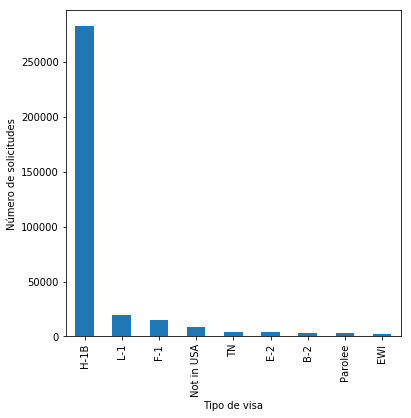

In [0]:
# Gráfica de categorías de visas con más de 1000 solicitudes
plt.figure(figsize=(10,10))
visas.class_of_admission.value_counts()[visas_1000].plot(kind="bar", figsize=(6,6), stacked=False)
plt.ylabel('Número de solicitudes')
plt.xlabel('Tipo de visa')

Cada tipo de visa puede obtener 4 clases de resultados diferentes: Certified, Certified-Expired, Denied y Withdrawn. Para la visa H-1B la distribución del resultado obtenido se muestra continuación.

In [0]:
# Número de casos en cada categoría del status para las visas H-1B
(visas[visas.class_of_admission=="H-1B"])['case_status'].value_counts()

Certified            139312
Certified-Expired    116842
Denied                14313
Withdrawn             12551
Name: case_status, dtype: int64

Text(0.5,0,'Resultado de la solicitud')

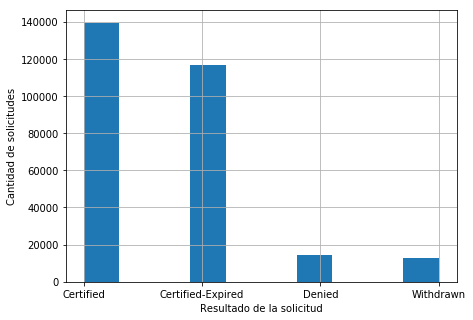

In [0]:
# Histograma de casos en cada categoría del status para las visas H-1B
plt.figure(figsize=(7,5))
(visas[visas.class_of_admission=="H-1B"])['case_status'].hist()
plt.ylabel('Cantidad de solicitudes')
plt.xlabel('Resultado de la solicitud')

De acuerdo con estos resultados una baja proporción de las visas son denegadas. Lo cual indica que nuestro conjunto de datos está desbalanceado y debido a ello será necesario implementar algún método que equilibre la proporción de visas aceptadas y visas negadas, tal como se efectuará posteriormente. Otro problema que presentan los datos es que existen muchas variables con un elevado número de valores faltantes.

In [0]:
# Número de casos faltantes en cada variable
visas.isnull().sum()

add_these_pw_job_title_9089               332168
agent_city                                162908
agent_firm_name                           167365
agent_state                               166123
application_type                          239093
case_no                                   239093
case_number                               135269
case_received_date                        135271
case_status                                    0
class_of_admission                         22845
country_of_citizenship                     20633
country_of_citzenship                     353788
decision_date                                  0
employer_address_1                            42
employer_address_2                        149192
employer_city                                 14
employer_country                          135343
employer_decl_info_title                  135308
employer_name                                 12
employer_num_employees                    135349
employer_phone      

Se muestra a continuación el resultado de las solicitudes presentadas cada año. La cifra de solicitudes aceptadas mantiene una tendencia de crecimiento y alcanza su máximo en 2016. Llama la atención que la cantidad de solicitudes denegadas muestra poca variación, especialmente a partir de 2013.

Text(0.5,0,'Año de solicitud')

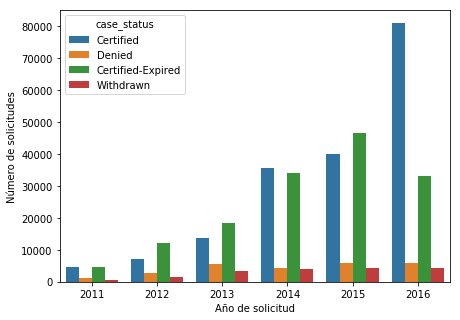

In [0]:
# Conversión de la fecha para que contenga solo el año de presentación de la solicitud
# Adaptado parcialmente de https://www.kaggle.com/elzawie/us-permanent-visa-applications-v1-1

year = []

for date in visas['decision_date']:
    year.append(pd.to_datetime(date).year)
    
visas['decision_year'] = year

plt.figure(figsize=(7,5))
sns.countplot(x="decision_year", hue="case_status", data=visas)
plt.ylabel('Número de solicitudes')
plt.xlabel('Año de solicitud')

La mayoría de variables que conforma el conjunto de datos es de tipo categórico. Al realizar la descripción de las variables numéricas se puede afirmar que existen notables diferencias en la escala de estas variables, razón por la cual será necesario llevar a cabo algún tipo de escalamiento.

In [0]:
# Lista de variables numéricas
visas._get_numeric_data().columns

Index(['employer_num_employees', 'employer_yr_estab',
       'foreign_worker_yr_rel_edu_completed', 'fw_info_yr_rel_edu_completed',
       'job_info_alt_cmb_ed_oth_yrs', 'job_info_alt_occ_num_months',
       'job_info_experience_num_months', 'job_info_training_num_months',
       'wage_offered_from_9089', 'wage_offered_to_9089', 'decision_year'],
      dtype='object')

In [0]:
# Estadísticos de las variables numéricas
with pd.option_context('float_format', '{:.2f}'.format): print(visas.describe())

       employer_num_employees  employer_yr_estab  \
count               239013.00          238958.00   
mean                 23093.87            1984.21   
std                 545312.85              38.47   
min                      0.00               0.00   
25%                     73.00            1980.00   
50%                   1200.00            1996.00   
75%                  16134.00            2004.00   
max              263550614.00            2016.00   

       foreign_worker_yr_rel_edu_completed  fw_info_yr_rel_edu_completed  \
count                             83364.00                     137198.00   
mean                               2001.35                       2002.63   
std                                  91.44                         89.67   
min                                   0.00                          0.00   
25%                                2003.00                       2004.00   
50%                                2006.00                       2007.00   

## Preprocesamiento de los datos

Tal como se mencionó anteriormente, nuestro trabajo se concentrará en el análisis de la categoría de visa H-1B. Es por ello que se creó un nuevo conjunto de datos en el que únicamente se incluyen éstas. 

In [0]:
# Creación de un nuevo dataset que incluye solamente las visas de categoría H-1B
visasH = visas
visasH = visasH[visasH.class_of_admission == 'H-1B']

Dado que tanto el status Certified-Expired como Withdrawn corresponden a decisiones que toman el empleado en el primer caso, y el empleador en el otro caso, se optó por retirar aquellas observaciones cuyo status corresponda a estos resultados. 

In [0]:
# Eliminación de los casos cuyo status es Certified-Expired o Withdrawn
visasH = visasH[visasH.case_status != 'Certified-Expired']
visasH = visasH[visasH.case_status != 'Withdrawn']

In [0]:
visasH['case_status'].value_counts()

Certified    139312
Denied        14313
Name: case_status, dtype: int64

Otro problema del conjunto de datos es que algunas variables como es el caso de pw_amount_9089 y wage_offer_from_9089 (tipos de salario) poseen datos que en apariencia son numéricos pero en realidad mezclan datos de tipo float y str. Además, no todos los salarios que conforman esta variable se miden usando la misma unidad. Por tales razones es necesario procesar estas variables del modo que se muestra a continuación.

In [0]:
visasH[['pw_amount_9089','pw_unit_of_pay_9089']].head(10)

,pw_amount_9089,pw_unit_of_pay_9089
2,47923,yr
8,44824,yr
11,46176,yr
12,34.3,hr
13,74672,yr
16,28.05,hr
20,141731,yr
24,NaN,NaN
28,38646,yr
32,23340,yr


In [0]:
# Máscara para seleccionar solamente los valores de tipo str en la variable pw_amount_9089
msk = [(type(i)==str) for i in visasH['pw_amount_9089']]

# Reemplazo de la coma por un espacio en blanco para los valores tipo str
visasH['pw_amount_9089'][msk] = visasH['pw_amount_9089'][msk].str.replace(",", "")

In [0]:
# Fuente: https://www.kaggle.com/elzawie/us-permanent-visa-applications-v1-1
# Reemplazo de la unidad de pago en los valores diferentes al año

for unit in visasH.pw_unit_of_pay_9089.unique():
    if unit == "hr" or unit == "Hour":
        visasH.loc[visasH['pw_unit_of_pay_9089'] == unit, 'pw_amount_9089'] = visasH['pw_amount_9089'].apply(lambda x: float(x) * 8 * 250)
        visasH.loc[visasH['pw_unit_of_pay_9089'] == unit, 'pw_unit_of_pay_9089'] = visasH['pw_unit_of_pay_9089'].replace(to_replace = unit, value = "Year") 
    elif unit == "wk" or unit == "Week":
        visasH.loc[visasH['pw_unit_of_pay_9089'] == unit, 'pw_amount_9089'] = visasH['pw_amount_9089'].apply(lambda x: float(x) * 50)
        visasH.loc[visasH['pw_unit_of_pay_9089'] == unit, 'pw_unit_of_pay_9089'] = visasH['pw_unit_of_pay_9089'].replace(to_replace = unit, value = "Year")
    elif unit == "mth" or unit == "Month":
        visasH.loc[visasH['pw_unit_of_pay_9089'] == unit, 'pw_amount_9089'] = visasH['pw_amount_9089'].apply(lambda x: float(x) * 12)
        visasH.loc[visasH['pw_unit_of_pay_9089'] == unit, 'pw_unit_of_pay_9089'] = visasH['pw_unit_of_pay_9089'].replace(to_replace = unit, value = "Year")
    elif unit == "bi" or unit == "Bi-Weekly":  
        visasH.loc[visasH['pw_unit_of_pay_9089'] == unit, 'pw_amount_9089'] = visasH['pw_amount_9089'].apply(lambda x: float(x) * 25)
        visasH.loc[visasH['pw_unit_of_pay_9089'] == unit, 'pw_unit_of_pay_9089'] = visasH['pw_unit_of_pay_9089'].replace(to_replace = unit, value = "Year")
    elif unit =="yr":
        visasH.loc[visasH['pw_unit_of_pay_9089'] == unit ,'pw_unit_of_pay_9089'] = visasH['pw_unit_of_pay_9089'].replace(to_replace = unit, value = "Year")
    else:
        continue

# Reemplazo de valores faltantes con la mediana
visasH['pw_amount_9089'].fillna(visasH['pw_amount_9089'].median(), inplace=True)

# Cambio del formato de string a float
visasH['pw_amount_9089'] = visasH.pw_amount_9089.astype(float)

# Muestra de los 10 primeros valores
visasH[['pw_amount_9089','pw_unit_of_pay_9089']].head(10)

,pw_amount_9089,pw_unit_of_pay_9089
2,47923.0,Year
8,44824.0,Year
11,46176.0,Year
12,68600.0,Year
13,74672.0,Year
16,56100.0,Year
20,141731.0,Year
24,89378.0,NaN
28,38646.0,Year
32,23340.0,Year


In [0]:
# Descripción de la variable 'pw_amount_9089'
with pd.option_context('float_format', '{:.2f}'.format): print(visasH.pw_amount_9089.describe())

count      153625.00
mean       528856.64
std       8343919.15
min            11.84
25%         74100.00
50%         89378.00
75%        106912.00
max     288038000.00
Name: pw_amount_9089, dtype: float64


Al realizar la descripción de la variable pw_amount_9089 se observa que todos sus valores son ahora numéricos. Los resultados sugieren que existen valores atípicos, los cuales serán eliminados.

In [0]:
# Eliminación de valores atípicos de la variable 'pw_amount_9089'
q1 = visasH['pw_amount_9089'].quantile(.25)
q3 = visasH['pw_amount_9089'].quantile(.75)
IQR = q3 - q1
msk = visasH['pw_amount_9089'].between(q1-2.0*IQR, q3+3.0*IQR, inclusive=True)
visasH = visasH[msk]

La eliminación de valores atípicos trae consigo una pequeña disminución en el número de observaciones.

In [0]:
visasH.shape

(152459, 155)

In [0]:
with pd.option_context('float_format', '{:.2f}'.format): print(visasH.pw_amount_9089.describe())

count   152459.00
mean     91269.81
std      28030.70
min      15080.00
25%      74085.50
50%      89378.00
75%     106551.50
max     205296.00
Name: pw_amount_9089, dtype: float64


Se realizó un tratamiento similar a la variable wage_offer_from_9089.

In [0]:
# Máscara para seleccionar solamente los valores de tipo str en la variable wage_offer_from_9089
msk2 = [(type(i)==str) for i in visasH['wage_offer_from_9089']]

# Reemplazo de la coma por un espacio en blanco para los valores tipo str
visasH['wage_offer_from_9089'][msk2] = visasH['wage_offer_from_9089'][msk2].str.replace(",", "")

In [0]:
# Reemplazo de la unidad de pago en los valores diferentes al año

for unit in visasH.wage_offer_unit_of_pay_9089.unique():
    if unit == "hr" or unit == "Hour":
        visasH.loc[visasH['wage_offer_unit_of_pay_9089'] == unit, 'wage_offer_from_9089'] = visasH['wage_offer_from_9089'].apply(lambda x: (x) * 8 * 250)
        visasH.loc[visasH['wage_offer_unit_of_pay_9089'] == unit, 'wage_offer_unit_of_pay_9089'] = visasH['wage_offer_unit_of_pay_9089'].replace(to_replace = unit, value = "Year") 
    elif unit == "wk" or unit == "Week":
        visasH.loc[visasH['wage_offer_unit_of_pay_9089'] == unit, 'wage_offer_from_9089'] = visasH['wage_offer_from_9089'].apply(lambda x: (x) * 50)
        visasH.loc[visasH['wage_offer_unit_of_pay_9089'] == unit, 'wage_offer_unit_of_pay_9089'] = visasH['wage_offer_unit_of_pay_9089'].replace(to_replace = unit, value = "Year")
    elif unit == "mth" or unit == "Month":
        visasH.loc[visasH['wage_offer_unit_of_pay_9089'] == unit, 'wage_offer_from_9089'] = visasH['wage_offer_from_9089'].apply(lambda x: (x) * 12)
        visasH.loc[visasH['wage_offer_unit_of_pay_9089'] == unit, 'wage_offer_unit_of_pay_9089'] = visasH['wage_offer_unit_of_pay_9089'].replace(to_replace = unit, value = "Year")
    elif unit == "bi" or unit == "Bi-Weekly":  
        visasH.loc[visasH['wage_offer_unit_of_pay_9089'] == unit, 'wage_offer_from_9089'] = visasH['wage_offer_from_9089'].apply(lambda x: (x) * 25)
        visasH.loc[visasH['wage_offer_unit_of_pay_9089'] == unit, 'wage_offer_unit_of_pay_9089'] = visasH['wage_offer_unit_of_pay_9089'].replace(to_replace = unit, value = "Year")
    elif unit =="yr":
        visasH.loc[visasH['wage_offer_unit_of_pay_9089'] == unit ,'wage_offer_unit_of_pay_9089'] = visasH['wage_offer_unit_of_pay_9089'].replace(to_replace = unit, value = "Year")
    else:
        continue   

La variable pw_soc_code que corresponde al código ocupacional asociado al trabajo solicitado también fue tratada para eliminar las comas, imputar valores faltantes y convertir sus datos a tipo numérico. 

In [0]:
# Reemplazo de '.' y '-' por espacios en blanco en los valores de 'pw_soc_code'
visasH['pw_soc_code'] = visasH['pw_soc_code'].str.replace('.','')
visasH['pw_soc_code'] = visasH['pw_soc_code'].str.replace('-','')
visasH['pw_soc_code'] = visasH['pw_soc_code'].astype(str).str[0:6]
visasH['pw_soc_code'].value_counts()

# Reemplazo de los valores "NaN" en 'pw_soc_code' por la moda
visasH.loc[visasH['pw_soc_code'] == "nan",'pw_soc_code'] = visasH['pw_soc_code'].mode()[0]

# Reemplazo de los valores "None" en 'pw_soc_code' por la moda
visasH.loc[visas['pw_soc_code'] == "None",'pw_soc_code'] = visasH['pw_soc_code'].mode()[0]

# Conversión de los valores a int
visasH['pw_soc_code'] = visasH['pw_soc_code'].astype(int)

También es necesario imputar valores faltantes en la variable employer_name. A continuación, se crean dos variables: num_applications_EMP que corresponde al número de solicitudes presentadas por cada empleador y acceptance_rate_EMP que representa la proporción entre el número de solicitudes aceptadas y el número de solicitudes totales de cada empleador. Se crearon estas variables debido a que en algunos trabajos analizados en el Estado del Arte señalan que son importantes para la predicción de los resultados de las solicitudes de visa. 

In [0]:
# Reemplazo de valores faltantes en el nombre del empleador por la moda
visasH['employer_name'] = visasH['employer_name'].fillna((visasH['employer_name'].mode()[0]))

# Convertir nombres a mayúscula
visasH['employer_name'] = visasH['employer_name'].astype(str).str.upper()

In [0]:
# Creación de la variable 'num_applications_EMP' (número de solicitudes presentadas por cada empleador anualmente)
# Creación de la variable 'acceptance_rate_EMP' (tasa de éxitos de las solicitudes presentadas por cada empleador anualmente)
num_applications = np.zeros(visasH.shape[0],dtype = int)
acc_rate = np.zeros(visasH.shape[0],dtype = float)
for year in visasH['decision_year'].unique():
    visas_y = visasH[visasH['decision_year'] == year]
    num_apps = visas_y.employer_name.value_counts()
    num_exitos = (visas_y[visas_y.case_status=='Certified'])['employer_name'].value_counts()
    tasa_exitos = num_exitos/num_apps
    for i in range(visasH.shape[0]):
        if visasH['decision_year'].iloc[i] == year:
            num_applications[i] = (num_apps[visasH['employer_name'].iloc[i]])
            acc_rate[i] = (tasa_exitos[visasH['employer_name'].iloc[i]])

visasH['num_applications_EMP'] = num_applications  
visasH['acceptance_rate_EMP'] = acc_rate

# Imputación de valores faltantes con la mediana
visasH['acceptance_rate_EMP'].fillna(visasH['acceptance_rate_EMP'].median(), inplace=True)

También se crearon las variables: num_applications_SOC que corresponde al número de solicitudes presentadas por cada sector ocupacional y acceptance_rate_SOC que representa la proporción entre el número de solicitudes aceptadas y el número de solicitudes totales de cada sector ocupacional.

In [0]:
# Creación de la variable 'num_applications_SOC' (número de solicitudes presentadas por cada sector ocupacional anualmente)
# Creación de la variable 'acceptance_rate_SOC' (tasa de éxitos de las solicitudes presentadas por cada sector ocupacional anualmente)
num_applications = np.zeros(visasH.shape[0],dtype = int)
acc_rate = np.zeros(visasH.shape[0],dtype = float)
for year in visasH['decision_year'].unique():
    visas_y = visasH[visasH['decision_year'] == year]
    num_apps = visas_y.pw_soc_code.value_counts()
    num_exitos = (visas_y[visas_y.case_status=='Certified'])['pw_soc_code'].value_counts()
    tasa_exitos = num_exitos/num_apps
    for i in range(visasH.shape[0]):
        if visasH['decision_year'].iloc[i] == year:
            num_applications[i] = (num_apps[visasH['pw_soc_code'].iloc[i]])
            acc_rate[i] = (tasa_exitos[visasH['pw_soc_code'].iloc[i]])

visasH['num_applications_SOC'] = num_applications  
visasH['acceptance_rate_SOC'] = acc_rate

# Imputación de valores faltantes con la mediana
visasH['acceptance_rate_SOC'].fillna(visasH['acceptance_rate_SOC'].median(), inplace=True)

Se decidió eliminar aquellas variables que poseen más de un 50% de valores nulos, al igual que aquellas variables categóricas que solamente poseen una categoría. La nueva lista de variables categóricas se muestra a continuación.

In [0]:
# Eliminación de variables con más del 50% de casos nulos
porcentaje_nulo = visasH.isnull().sum() / len(visasH)
missing_features = porcentaje_nulo[porcentaje_nulo > 0.50].index
visasH.drop(missing_features, axis=1, inplace=True)

In [0]:
# Cuenta de valores únicos en cada variable
unicos_var = visasH.T.apply(lambda x: x.nunique(), axis=1)

In [0]:
# Eliminación de variables que tengan un sólo valor único
solo_var = []
for i in range(visasH.shape[1]):
    if unicos_var[visasH.columns[i]] == 1: 
        solo_var.append(visasH.columns[i])

visasH.drop(visasH[solo_var], axis=1, inplace=True)

In [0]:
# Lista de variables categóricas
all_columns = visasH.columns
num_columns = visasH._get_numeric_data().columns
cat_columns = list(set(all_columns) - set(num_columns))
cat_columns

['wage_offer_from_9089',
 'case_received_date',
 'job_info_foreign_lang_req',
 'job_info_work_postal_code',
 'agent_state',
 'decision_date',
 'foreign_worker_info_inst',
 'job_info_alt_field',
 'ri_2nd_ad_newspaper_name',
 'pw_level_9089',
 'preparer_info_emp_completed',
 'employer_decl_info_title',
 'job_info_alt_combo_ed_exp',
 'foreign_worker_info_city',
 'job_info_experience',
 'ri_job_search_website_from',
 'pw_source_name_9089',
 'recr_info_employer_rec_payment',
 'job_info_job_req_normal',
 'pw_determ_date',
 'ri_layoff_in_past_six_months',
 'foreign_worker_info_state',
 'pw_soc_title',
 'recr_info_sunday_newspaper',
 'recr_info_swa_job_order_end',
 'foreign_worker_info_education',
 'pw_track_num',
 'employer_country',
 'job_info_major',
 'employer_address_2',
 'job_info_foreign_ed',
 'ri_1st_ad_newspaper_name',
 'job_info_training',
 'recr_info_coll_univ_teacher',
 'job_info_work_city',
 'employer_address_1',
 'preparer_info_title',
 'ri_posted_notice_at_worksite',
 'agent_fir

Otra decisión adoptada fue la eliminación de aquellas variables categóricas que poseen demasiadas categorías (su número excede a la cantidad de códigos ocupacionales). Estas variables como es el caso de la dirección del empleador seguramente no aportarán información relevante a la tarea de clasificación y tampoco resulta útil asignarle código a cada una de las categorías. 

In [0]:
# Número de valores únicos en las variables categóricas
unicos_cat = visasH[cat_columns].T.apply(lambda x: x.nunique(), axis=1)

In [0]:
visasH.shape

(152459, 71)

In [0]:
# Eliminación de variables cuyo número de categorías es mayor al número de códigos ocupacionales
lim = len(visasH['pw_soc_code'].unique())
muchos_var = []
for var in unicos_cat.index:
    if unicos_cat[var] > lim: 
        muchos_var.append(var)

visasH.drop(visasH[muchos_var], axis=1, inplace=True)

In [0]:
# Nueva lista de variables categóricas
all_columns = visasH.columns
num_columns = visasH._get_numeric_data().columns
cat_columns = list(set(all_columns) - set(num_columns))

Luego de imputar los valores faltantes de las variables numéricas con la mediana y de las variables categóricas con la moda se verifica que ya no existen valores nulos en el conjunto de datos. 

In [0]:
# Imputación de valores faltantes en variables numéricas con la mediana
for i in range(len(num_columns)):
    visasH[num_columns[i]].fillna(visasH[num_columns[i]].median(), inplace=True)

In [0]:
# Imputación de valores faltantes en variables categóricas con la moda
for i in range(len(cat_columns)):
    visasH[cat_columns[i]].fillna(visasH[cat_columns[i]].value_counts().index[0], inplace=True)

In [0]:
visasH.isnull().sum()

agent_state                       0
case_status                       0
country_of_citizenship            0
employer_country                  0
employer_num_employees            0
employer_state                    0
employer_yr_estab                 0
foreign_worker_info_education     0
foreign_worker_info_state         0
ji_live_in_domestic_service       0
job_info_alt_combo_ed_exp         0
job_info_alt_field                0
job_info_combo_occupation         0
job_info_education                0
job_info_experience               0
job_info_foreign_ed               0
job_info_foreign_lang_req         0
job_info_job_req_normal           0
job_info_training                 0
job_info_work_state               0
preparer_info_emp_completed       0
pw_amount_9089                    0
pw_level_9089                     0
pw_soc_code                       0
pw_source_name_9089               0
recr_info_coll_univ_teacher       0
recr_info_employer_rec_payment    0
recr_info_professional_occ  

En el caso de las variables cuyas categorías corresponden a los nombres de los estados, se aprecia que algunas veces se representan los nombres de forma completa o en ocasiones se usa la abreviatura. Se optó por convertir todos los nombres completos a la abreviatura respectiva. 

In [0]:
visasH['employer_state'].unique()

array(['VA', 'DE', 'NY', 'NJ', 'GA', 'TX', 'KY', 'MS', 'MA', 'CA', 'NC',
       'MO', 'MD', 'OH', 'IL', 'WA', 'AL', 'FL', 'OK', 'DC', 'NV', 'CT',
       'MN', 'IA', 'PA', 'MI', 'NE', 'KS', 'TN', 'PR', 'OR', 'AR', 'CO',
       'WY', 'VI', 'LA', 'AZ', 'ND', 'UT', 'NH', 'RI', 'WI', 'IN', 'ID',
       'VT', 'ME', 'HI', 'GU', 'SC', 'NM', 'WV', 'SD', 'AK', 'MT',
       'TEXAS', 'CALIFORNIA', 'WASHINGTON', 'ARIZONA', 'MASSACHUSETTS',
       'MICHIGAN', 'PENNSYLVANIA', 'VIRGINIA', 'NEW YORK', 'MARYLAND',
       'MISSOURI', 'INDIANA', 'ILLINOIS', 'UTAH', 'NEW JERSEY',
       'DELAWARE', 'LOUISIANA', 'OHIO', 'OKLAHOMA', 'FLORIDA', 'GEORGIA',
       'KANSAS', 'WISCONSIN', 'NEBRASKA', 'DISTRICT OF COLUMBIA',
       'NEW MEXICO', 'TENNESSEE', 'RHODE ISLAND', 'VERMONT', 'COLORADO',
       'CONNECTICUT', 'NORTH CAROLINA', 'KENTUCKY', 'MINNESOTA',
       'ARKANSAS', 'WEST VIRGINIA', 'ALABAMA', 'NEW HAMPSHIRE', 'OREGON',
       'MISSISSIPPI', 'MAINE', 'IOWA', 'PUERTO RICO', 'HAWAII', 'ALASKA',
       '

In [0]:
# Fuente: https://www.kaggle.com/elzawie/us-permanent-visa-applications-v1-1
# Correspondencia entre el nombre del estado y la abreviatura mediante un diccionario
state_abbrevs = {
    'Alabama': 'AL',
    'Alaska': 'AK',
    'Arizona': 'AZ',
    'Arkansas': 'AR',
    'California': 'CA',
    'Colorado': 'CO',
    'Connecticut': 'CT',
    'Delaware': 'DE',
    'Florida': 'FL',
    'Georgia': 'GA',
    'Guam': 'GU',
    'Hawaii': 'HI',
    'Idaho': 'ID',
    'Illinois': 'IL',
    'Indiana': 'IN',
    'Iowa': 'IA',
    'Kansas': 'KS',
    'Kentucky': 'KY',
    'Louisiana': 'LA',
    'Maine': 'ME',
    'Maryland': 'MD',
    'Massachusetts': 'MA',
    'Michigan': 'MI',
    'Minnesota': 'MN',
    'Mississippi': 'MS',
    'Missouri': 'MO',
    'Montana': 'MT',
    'Nebraska': 'NE',
    'Nevada': 'NV',
    'New Hampshire': 'NH',
    'New Jersey': 'NJ',
    'New Mexico': 'NM',
    'New York': 'NY',
    'North Carolina': 'NC',
    'North Dakota': 'ND',
    'Ohio': 'OH',
    'Oklahoma': 'OK',
    'Oregon': 'OR',
    'Pennsylvania': 'PA',
    'Rhode Island': 'RI',
    'South Carolina': 'SC',
    'South Dakota': 'SD',
    'Tennessee': 'TN',
    'Texas': 'TX',
    'Utah': 'UT',
    'Vermont': 'VT',
    'Virginia': 'VA',
    'Washington': 'WA',
    'West Virginia': 'WV',
    'Wisconsin': 'WI',
    'Wyoming': 'WY',
    'Northern Mariana Islands':'MP', 
    'Palau': 'PW', 
    'Puerto Rico': 'PR', 
    'Virgin Islands': 'VI', 
    'District of Columbia': 'DC',
    'British Columbia': 'BC',
}

# Conversión de las claves del diccionario a letras mayúsculas
us_state_abbrev = {k.upper(): v for k, v in state_abbrevs.items()}
vars_state = ['agent_state','job_info_work_state','foreign_worker_info_state','employer_state']
for var in vars_state:
    visasH[var].replace(us_state_abbrev, inplace=True)
    visasH[var] = visasH[var].astype(str)

In [0]:
visasH['employer_state'].unique()

array(['VA', 'DE', 'NY', 'NJ', 'GA', 'TX', 'KY', 'MS', 'MA', 'CA', 'NC',
       'MO', 'MD', 'OH', 'IL', 'WA', 'AL', 'FL', 'OK', 'DC', 'NV', 'CT',
       'MN', 'IA', 'PA', 'MI', 'NE', 'KS', 'TN', 'PR', 'OR', 'AR', 'CO',
       'WY', 'VI', 'LA', 'AZ', 'ND', 'UT', 'NH', 'RI', 'WI', 'IN', 'ID',
       'VT', 'ME', 'HI', 'GU', 'SC', 'NM', 'WV', 'SD', 'AK', 'MT', 'MP',
       'BC'], dtype=object)

Las categorías de todas las variables categóricas excepto case_status (variable a predecir) se codifican asignando un número entero mayor o igual a 1. 

In [0]:
cat_columns

['job_info_foreign_lang_req',
 'ri_posted_notice_at_worksite',
 'agent_state',
 'case_status',
 'job_info_alt_field',
 'pw_level_9089',
 'job_info_work_state',
 'preparer_info_emp_completed',
 'job_info_alt_combo_ed_exp',
 'job_info_education',
 'job_info_training',
 'job_info_experience',
 'ri_2nd_ad_newspaper_or_journal',
 'recr_info_professional_occ',
 'country_of_citizenship',
 'pw_source_name_9089',
 'recr_info_employer_rec_payment',
 'job_info_job_req_normal',
 'ri_layoff_in_past_six_months',
 'foreign_worker_info_state',
 'recr_info_sunday_newspaper',
 'foreign_worker_info_education',
 'employer_state',
 'employer_country',
 'job_info_combo_occupation',
 'job_info_foreign_ed',
 'ji_live_in_domestic_service',
 'recr_info_coll_univ_teacher']

In [0]:
cat_columns.remove('case_status')

In [0]:
# Codificación de las variables categóricas
cat_dict = dict()
for var in cat_columns:
    visasH[var] = visasH[var].astype('category')
    cat_dict[var] = {i+1:c for i,c in enumerate(visasH[var].cat.categories)} # list comprehension
    visasH[var] = visasH[var].cat.codes+1

En el caso de las variables numéricas cuyos valores no están comprendidos entre 0 y 1 se utilizó el escalamiento Min-Max para su normalización.

In [0]:
# Creación de lista de variables numéricas no-escaladas
num_columns_no_scale = list(set(num_columns))
num_columns_no_scale.remove('acceptance_rate_EMP')
num_columns_no_scale.remove('acceptance_rate_SOC')

In [0]:
num_columns_no_scale

['num_applications_EMP',
 'pw_amount_9089',
 'employer_num_employees',
 'pw_soc_code',
 'decision_year',
 'num_applications_SOC',
 'employer_yr_estab']

In [0]:
with pd.option_context('float_format', '{:.2f}'.format): print(visasH[num_columns_no_scale].describe())

       num_applications_EMP  pw_amount_9089  employer_num_employees  \
count             152459.00       152459.00               152459.00   
mean                 159.65        91269.81                16624.54   
std                  486.60        28030.70                79656.72   
min                    1.00        15080.00                    0.00   
25%                    2.00        74085.50                  590.00   
50%                    8.00        89378.00                 1840.00   
75%                   52.00       106551.50                 5400.00   
max                 2978.00       205296.00             16333318.00   

       pw_soc_code  decision_year  num_applications_SOC  employer_yr_estab  
count    152459.00      152459.00             152459.00          152459.00  
mean     167000.58        2014.73               6835.20            1987.49  
std       48603.11           1.36               8761.15              32.11  
min      111011.00        2011.00                  1

In [0]:
# Escalamiento Min-Max de variables numéricas
from sklearn import preprocessing
scaler = preprocessing.MinMaxScaler()
visasH[num_columns_no_scale] = scaler.fit_transform(visasH[num_columns_no_scale])

Se crea a continuación una lista que contiene la lista de atributos, se asigna el nombre target a la variable a predecir y se codifica ésta asignando el valor 1 a los casos de visas aceptadas y -1 a los casos de visas denegadas.  

In [0]:
feat_columns = visasH.columns
feat_columns = list(set(feat_columns))
feat_columns.remove('case_status')

In [0]:
# Creación de la variable target y codificación de la variable a predecir
visasH['target'] = 2 * (visasH['case_status'] == 'Certified') - 1 
print(visasH['target'].value_counts())

 1    138329
-1     14130
Name: target, dtype: int64


En la vista preliminar del conjunto de datos se aprecia que las variables categóricas han sido codificadas satisfactoriamente y que la variable target se añadió al conjunto de datos.

In [0]:
visasH.head(10)

,agent_state,case_status,country_of_citizenship,employer_country,employer_num_employees,employer_state,employer_yr_estab,foreign_worker_info_education,foreign_worker_info_state,ji_live_in_domestic_service,...,recr_info_sunday_newspaper,ri_2nd_ad_newspaper_or_journal,ri_layoff_in_past_six_months,ri_posted_notice_at_worksite,decision_year,num_applications_EMP,acceptance_rate_EMP,num_applications_SOC,acceptance_rate_SOC,target
2,5,Certified,71,4,0.000113,50,0.99005,5,5,1,...,2,2,1,3,0.0,0.000000,1.000000,0.002076,0.903846,1
8,5,Certified,71,4,0.000113,10,0.99005,5,5,1,...,2,2,1,3,0.2,0.000000,1.000000,0.028449,0.805714,1
11,5,Certified,71,4,0.000113,38,0.99005,5,5,1,...,2,2,1,3,0.2,0.000000,1.000000,0.000285,0.875000,1
12,5,Certified,71,4,0.000113,35,0.99005,5,5,1,...,2,2,1,3,0.2,0.000000,1.000000,0.000204,0.666667,1
13,5,Certified,71,4,0.000113,12,0.99005,5,5,1,...,2,2,1,3,0.0,0.000000,1.000000,0.000814,0.904762,1
16,5,Certified,71,4,0.000113,35,0.99005,5,5,1,...,2,2,1,3,0.0,0.002687,0.222222,0.018681,0.882609,1
20,5,Certified,71,4,0.000113,48,0.99005,5,5,1,...,2,2,1,3,0.0,0.000000,1.000000,0.002523,0.952381,1
24,5,Denied,71,4,0.000113,20,0.99005,5,5,1,...,2,2,1,3,0.2,0.000000,1.000000,0.000285,0.875000,-1
28,5,Certified,71,4,0.000113,38,0.99005,5,5,1,...,2,2,1,3,0.2,0.001344,0.800000,0.005006,0.854839,1
32,5,Certified,71,4,0.000113,29,0.99005,5,5,1,...,2,2,1,3,0.0,0.000000,1.000000,0.000936,0.333333,1


Dado que los datos están desbalanceados se implementaron dos estrategias para crear dos conjuntos de datos balanceados: la primera consiste en llevar a cabo un sobremuestreo de la calse minoritaria y la segunda realiza un submuestreo de la clase mayoritaria. 

In [0]:
# Fuente: https://elitedatascience.com/imbalanced-classes
# Balanceo de los datos con sobremuestreo de la clase minoritaria y submuestreo de la clase mayoritaria
from sklearn.utils import resample

visas_negadas = visasH['target'].value_counts()[-1]
visas_aceptadas = visasH['target'].value_counts()[1]

visas_minoria = visasH[visasH['target']==-1]
visas_mayoria = visasH[visasH['target']==1]

visas_negadas_sobrem = resample(visas_minoria, replace=True, n_samples=visas_aceptadas, random_state=123)

visas_aceptadas_subm = resample(visas_mayoria, replace=True, n_samples=visas_negadas, random_state=123)

visasH_sobrem = pd.concat([visas_mayoria, visas_negadas_sobrem])

visasH_submst = pd.concat([visas_minoria, visas_aceptadas_subm])

In [0]:
visasH_sobrem['case_status'].value_counts()

Denied       138329
Certified    138329
Name: case_status, dtype: int64

In [0]:
visasH_submst['case_status'].value_counts()

Certified    14130
Denied       14130
Name: case_status, dtype: int64

In [0]:
# Creación de dos conjuntos de datos balanceados
X1 = visasH_sobrem[feat_columns]
y1 = visasH_sobrem['target']

X2 = visasH_submst[feat_columns]
y2 = visasH_submst['target']

### Conjuntos de Entrenamiento, Validación y Prueba

Para la creación de los conjuntos de entrenamiento, validación y prueba se optó por destinar el 60% de los datos para entrenamiento, el 20% para validación y el 20% para prueba. 

In [0]:
from sklearn.model_selection import train_test_split

X_trainval1, X_test1, y_trainval1, y_test1 = train_test_split(X1, y1, test_size=0.20, random_state=0)
X_train1, X_val1, y_train1, y_val1 = train_test_split(X_trainval1, y_trainval1, test_size=0.25, random_state=0)

X_trainval2, X_test2, y_trainval2, y_test2 = train_test_split(X2, y2, test_size=0.20, random_state=0)
X_train2, X_val2, y_train2, y_val2 = train_test_split(X_trainval2, y_trainval2, test_size=0.25, random_state=0)

In [0]:
with pd.option_context('float_format', '{:.2f}'.format): print(visasH.describe())

       agent_state  country_of_citizenship  employer_country  \
count    152459.00               152459.00         152459.00   
mean         14.86                   75.37              4.00   
std          14.76                   30.30              0.02   
min           1.00                    1.00              1.00   
25%           5.00                   71.00              4.00   
50%           5.00                   71.00              4.00   
75%          24.00                   71.00              4.00   
max          53.00                  178.00              4.00   

       employer_num_employees  employer_state  employer_yr_estab  \
count               152459.00       152459.00          152459.00   
mean                     0.00           26.25               0.99   
std                      0.00           16.90               0.02   
min                      0.00            1.00               0.00   
25%                      0.00            6.00               0.99   
50%            

### Random Forest

#### Conjunto de datos 1

En primer lugar se llevará a cabo una optimización del número de árboles mediante validación cruzada y posteriormente se usará este parámetro para opitimizar la profundidad. 

In [0]:
# Optimización del número de árboles
from sklearn.ensemble import RandomForestClassifier

mejor_score = 0
mejor_n_estimators = None
mejor_modelo_rf = None
rf_error_train = []
rf_error_val = []

n_estimators_grid = np.linspace(10,200,39).astype(int)  # ~ [10, 15, 20, ..., 200] 

for n_estimators in n_estimators_grid: 
    modelo_rf = RandomForestClassifier(n_estimators=n_estimators, random_state=0, n_jobs = -1)
    modelo_rf.fit(X_train1, y_train1)
    score_train = modelo_rf.score(X_train1, y_train1)
    rf_error_train.append(1 - score_train)
    score_val = modelo_rf.score(X_val1, y_val1)
    rf_error_val.append(1 - score_val)
    if score_val > mejor_score: 
        mejor_score = score_val
        mejor_n_estimators = n_estimators
        mejor_modelo_rf = modelo_rf

modelo_rf = mejor_modelo_rf
modelo_rf.fit(X_train1, y_train1)

print ("Mejor valor de n_estimators :", mejor_n_estimators)
print ("Exactitud de RandomForest en conjunto de entrenamiento :", modelo_rf.score(X_train1, y_train1))
print ("Exactitud de RandomForest en conjunto de validación    :", modelo_rf.score(X_val1, y_val1))

Mejor valor de n_estimators : 185
Exactitud de RandomForest en conjunto de entrenamiento : 0.9905237538706219
Exactitud de RandomForest en conjunto de validación    : 0.9697824043952866


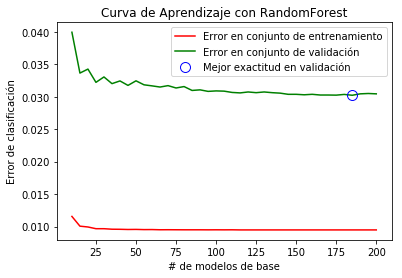

In [0]:
plt.figure()
plt.plot(n_estimators_grid, rf_error_train,
        label='Error en conjunto de entrenamiento',
        color='red')
plt.plot(n_estimators_grid, rf_error_val,
        label='Error en conjunto de validación',
        color='green')
plt.plot(mejor_n_estimators, 1-mejor_score, 'o', markersize=10,
         label="Mejor exactitud en validación", fillstyle="none", c='b', mew=1)
plt.xlabel("# de modelos de base")
plt.ylabel("Error de clasificación")
plt.title("Curva de Aprendizaje con RandomForest")
plt.legend(loc=0, numpoints=1)
plt.show()

In [0]:
from sklearn.model_selection import cross_val_score

rf_class = RandomForestClassifier(n_estimators=125)
print("Random Forests: ")
print(cross_val_score(rf_class, X_val1, y_val1, scoring='accuracy', cv = 10))
accuracy = cross_val_score(rf_class, X_val1, y_val1, scoring='accuracy', cv = 10).mean() * 100
print("Exactitud de Random Forests es: " , accuracy)
# Fuente: https://pythonforengineers.com/cross-validation-and-model-selection/

Random Forests: 
[0.91543188 0.90928804 0.90693892 0.91308276 0.91001084 0.90601843
 0.91451292 0.91359364 0.90798988 0.92118583]
Exactitud de Random Forests es:  91.2365569017551


Una vez validado el modelo se puede medir la exactitud, la precisión, la exhaustividad y el puntaje F1 en el conjunto de prueba:

In [0]:
from sklearn import metrics

m_rf = RandomForestClassifier(n_estimators=125, n_jobs=-1, random_state=0)
m_rf.fit(X_trainval1, y_trainval1)
predicciones_test_rf = m_rf.predict(X_test1)
accuracy_test = metrics.accuracy_score(y_test1, predicciones_test_rf) 
precision_test = metrics.precision_score(y_test1, predicciones_test_rf) 
recall_test = metrics.recall_score(y_test1, predicciones_test_rf) 
f1_test = metrics.f1_score(y_test1, predicciones_test_rf) 
print('Exactitud en el conjunto de prueba     : {:.4f}'.format(accuracy_test))
print('Precisión en el conjunto de prueba     : {:.4f}'.format(precision_test))
print('Exhaustividad en el conjunto de prueba : {:.4f}'.format(recall_test))
print('Puntaje F1 en el conjunto de prueba    : {:.4f}'.format(f1_test))

Exactitud en el conjunto de prueba     : 0.9748
Precisión en el conjunto de prueba     : 0.9969
Exhaustividad en el conjunto de prueba : 0.9525
Puntaje F1 en el conjunto de prueba    : 0.9742


#### Conjunto de datos 2

In [0]:
# Optimización del número de árboles
from sklearn.ensemble import RandomForestClassifier

mejor_score = 0
mejor_n_estimators = None
mejor_modelo_rf = None
rf_error_train = []
rf_error_val = []

n_estimators_grid = np.linspace(10,200,39).astype(int)  # ~ [10, 15, 20, ..., 200] 

for n_estimators in n_estimators_grid: 
    modelo_rf = RandomForestClassifier(n_estimators=n_estimators, random_state=0, n_jobs = -1)
    modelo_rf.fit(X_train2, y_train2)
    score_train = modelo_rf.score(X_train2, y_train2)
    rf_error_train.append(1 - score_train)
    score_val = modelo_rf.score(X_val2, y_val2)
    rf_error_val.append(1 - score_val)
    if score_val > mejor_score: 
        mejor_score = score_val
        mejor_n_estimators = n_estimators
        mejor_modelo_rf = modelo_rf

modelo_rf = mejor_modelo_rf
modelo_rf.fit(X_train2, y_train2)

print ("Mejor valor de n_estimators :", mejor_n_estimators)
print ("Exactitud de RandomForest en conjunto de entrenamiento :", modelo_rf.score(X_train2, y_train2))
print ("Exactitud de RandomForest en conjunto de validación    :", modelo_rf.score(X_val2, y_val2))

Mejor valor de n_estimators : 90
Exactitud de RandomForest en conjunto de entrenamiento : 0.9936305732484076
Exactitud de RandomForest en conjunto de validación    : 0.8244869072894551


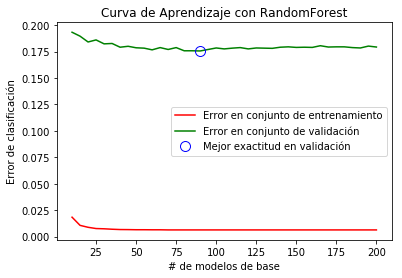

In [0]:
plt.figure()
plt.plot(n_estimators_grid, rf_error_train,
        label='Error en conjunto de entrenamiento',
        color='red')
plt.plot(n_estimators_grid, rf_error_val,
        label='Error en conjunto de validación',
        color='green')
plt.plot(mejor_n_estimators, 1-mejor_score, 'o', markersize=10,
         label="Mejor exactitud en validación", fillstyle="none", c='b', mew=1)
plt.xlabel("# de modelos de base")
plt.ylabel("Error de clasificación")
plt.title("Curva de Aprendizaje con RandomForest")
plt.legend(loc=0, numpoints=1)
plt.show()

In [0]:
from sklearn.model_selection import cross_val_score

rf_class = RandomForestClassifier(n_estimators=195)
print("Random Forests: ")
print(cross_val_score(rf_class, X_val2, y_val2, scoring='accuracy', cv = 10))
accuracy = cross_val_score(rf_class, X_val2, y_val2, scoring='accuracy', cv = 10).mean() * 100
print("Exactitud de Random Forests es: " , accuracy)
# Fuente: https://pythonforengineers.com/cross-validation-and-model-selection/

Random Forests: 
[0.80388693 0.77385159 0.82300885 0.81415929 0.82654867 0.82831858
 0.81769912 0.80884956 0.81061947 0.77168142]
Exactitud de Random Forests es:  81.12251790237343


In [0]:
from sklearn import metrics

m_rf = RandomForestClassifier(n_estimators=195, n_jobs=-1, random_state=0)
m_rf.fit(X_trainval2, y_trainval2)
predicciones_test_rf = m_rf.predict(X_test2)
accuracy_test = metrics.accuracy_score(y_test2, predicciones_test_rf) 
precision_test = metrics.precision_score(y_test2, predicciones_test_rf) 
recall_test = metrics.recall_score(y_test2, predicciones_test_rf) 
f1_test = metrics.f1_score(y_test2, predicciones_test_rf) 
print('Exactitud en el conjunto de prueba     : {:.4f}'.format(accuracy_test))
print('Precisión en el conjunto de prueba     : {:.4f}'.format(precision_test))
print('Exhaustividad en el conjunto de prueba : {:.4f}'.format(recall_test))
print('Puntaje F1 en el conjunto de prueba    : {:.4f}'.format(f1_test))

Exactitud en el conjunto de prueba     : 0.8197
Precisión en el conjunto de prueba     : 0.8361
Exhaustividad en el conjunto de prueba : 0.8045
Puntaje F1 en el conjunto de prueba    : 0.8200


Comparando la exactitud obtenida en los conjuntos 1 y 2 se aprecia que el método utilizado para balancear los datos tiene al parecer una influencia significativa en el desempeño del modelo de Random Forest. 

#### Importancia de los atributos

In [0]:
m_rf = RandomForestClassifier(n_estimators=125, n_jobs=-1, random_state=0)
m_rf.fit(X_train1, y_train1)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=125, n_jobs=-1,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

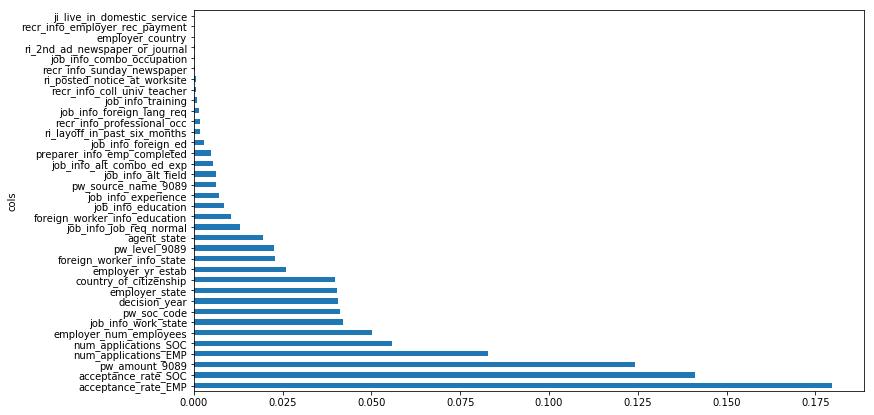

In [0]:
feat_importance = pd.DataFrame({'cols':X_train1.columns, 'imp':m_rf.feature_importances_}).sort_values('imp', ascending=False) 
feat_importance.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)

La gráfica anterior muestra que los 5 atributos que mayor peso tienen en la predicción del resultado de una solicitud de visa son la tasa de aceptación obtenida tanto por el empleador como por el sector ocupacional, el número de solicitudes que han sido presentadas anteriormente por el empleador, el número de empleados del empleador y el salario predominante.
Esta gráfica también sugiere que existe un grupo de atributos que no influyen en el resultado de la solicitud como el país del empleador, los cuales podrían eliminarse del conjunto de datos en futuros experimentos para mejorar el desempeño de los modelos.

In [0]:
# Creación de una lista que contiene solamente los atributos cuya importancia es mayor a 0.010
atrib_import = []
for i in range(len(feat_importance)):
    if feat_importance.iloc[i].imp > 0.0010:
        atrib_import.append(feat_importance.iloc[i].cols)     

In [0]:
# Modificación de los conjuntos de entrenamiento, validación y prueba tomando solamente los atributos más importantes
X_trainval1, X_train1, X_val1, X_test1= X_trainval1[atrib_import], X_train1[atrib_import], X_val1[atrib_import], X_test1[atrib_import]

X_trainval2, X_train2, X_val2, X_test2= X_trainval2[atrib_import], X_train2[atrib_import], X_val2[atrib_import], X_test2[atrib_import]

In [0]:
from sklearn.ensemble import RandomForestClassifier

mejor_score = 0
mejor_n_estimators = None
mejor_modelo_rf = None
rf_error_train = []
rf_error_val = []

n_estimators_grid = np.linspace(10,200,39).astype(int)  # ~ [10, 15, 20, ..., 200] 

for n_estimators in n_estimators_grid: 
    modelo_rf = RandomForestClassifier(n_estimators=n_estimators, random_state=0, n_jobs = -1)
    modelo_rf.fit(X_train2, y_train2)
    score_train = modelo_rf.score(X_train2, y_train2)
    rf_error_train.append(1 - score_train)
    score_val = modelo_rf.score(X_val2, y_val2)
    rf_error_val.append(1 - score_val)
    if score_val > mejor_score: 
        mejor_score = score_val
        mejor_n_estimators = n_estimators
        mejor_modelo_rf = modelo_rf

modelo_rf = mejor_modelo_rf
modelo_rf.fit(X_train2, y_train2)

print ("Mejor valor de n_estimators :", mejor_n_estimators)
print ("Exactitud de RandomForest en conjunto de entrenamiento :", modelo_rf.score(X_train2, y_train2))
print ("Exactitud de RandomForest en conjunto de validación    :", modelo_rf.score(X_val2, y_val2))

Mejor valor de n_estimators : 125
Exactitud de RandomForest en conjunto de entrenamiento : 0.9936305732484076
Exactitud de RandomForest en conjunto de validación    : 0.8244869072894551


In [0]:
from sklearn import metrics

m_rf = RandomForestClassifier(n_estimators=180, n_jobs=-1, random_state=0)
m_rf.fit(X_trainval2, y_trainval2)
predicciones_test_rf = m_rf.predict(X_test2)
accuracy_test = metrics.accuracy_score(y_test2, predicciones_test_rf) 
precision_test = metrics.precision_score(y_test2, predicciones_test_rf) 
recall_test = metrics.recall_score(y_test2, predicciones_test_rf) 
f1_test = metrics.f1_score(y_test2, predicciones_test_rf) 
print('Exactitud en el conjunto de prueba     : {:.4f}'.format(accuracy_test))
print('Precisión en el conjunto de prueba     : {:.4f}'.format(precision_test))
print('Exhaustividad en el conjunto de prueba : {:.4f}'.format(recall_test))
print('Puntaje F1 en el conjunto de prueba    : {:.4f}'.format(f1_test))

Exactitud en el conjunto de prueba     : 0.8176
Precisión en el conjunto de prueba     : 0.8347
Exhaustividad en el conjunto de prueba : 0.8014
Puntaje F1 en el conjunto de prueba    : 0.8177


### Regresión Logística

#### Conjunto 1

In [0]:
from sklearn.linear_model import LogisticRegression

mejor_score = 0
mejor_C = None
mejor_modelo_log = None

C_grid = np.logspace(-2,4,13)  # ~ [0.01, 0.03, 0.1, ..., 10000] 

for C in C_grid:
    ml = LogisticRegression(C=C, random_state=0)
    ml.fit(X_train1, y_train1)
    score_train = ml.score(X_train1, y_train1)
    score_val = ml.score(X_val1, y_val1)
    
    if score_val > mejor_score: 
        mejor_score = score_val
        mejor_C = C
        mejor_modelo_log = ml

modelo_log = mejor_modelo_log
modelo_log.fit(X_train1, y_train1)
    
print ("Mejor valor de C :", mejor_C)
print ("Exactitud de Regresión Logística en conjunto de entrenamiento :", modelo_log.score(X_train1, y_train1))
print ("Exactitud de Regresión Logística en conjunto de validación    :", modelo_log.score(X_val1, y_val1))

Mejor valor de C : 0.1
Exactitud de Regresión Logística en conjunto de entrenamiento : 0.7601841030398689
Exactitud de Regresión Logística en conjunto de validación    : 0.7625966890768452


In [0]:
log_class1 = LogisticRegression(C=0.1)
print("\n\n Regresión Logistica:")
print(cross_val_score(log_class1, X_val1, y_val1, scoring='accuracy', cv = 10))
accuracy = cross_val_score(log_class1, X_val1, y_val1, scoring='accuracy', cv = 10).mean() * 100
print("Exactitud de Regresión Logística: " , accuracy)
 #https://pythonforengineers.com/cross-validation-and-model-selection/



 Regresión Logistica:
[0.76093242 0.7580412  0.75406578 0.76147452 0.75352367 0.7565516
 0.75908187 0.76373825 0.75542299 0.76464208]
Exactitud de Regresión Logística:  75.87474383831604


In [0]:
ml_1 = LogisticRegression(C=0.1) 
ml_1.fit(X_trainval1, y_trainval1)

LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [0]:
ml_1.score(X_test1, y_test1)

0.752765126870527

#### Conjunto 2

In [0]:
from sklearn.linear_model import LogisticRegression

mejor_score = 0
mejor_C = None
mejor_modelo_log = None

C_grid = np.logspace(-2,4,13)  # ~ [0.01, 0.03, 0.1, ..., 10000] 

for C in C_grid:
    ml = LogisticRegression(C=C, random_state=0)
    ml.fit(X_train2, y_train2)
    score_train = ml.score(X_train2, y_train2)
    score_val = ml.score(X_val2, y_val2)
    
    if score_val > mejor_score: 
        mejor_score = score_val
        mejor_C = C
        mejor_modelo_log = ml

modelo_log = mejor_modelo_log
modelo_log.fit(X_train2, y_train2)
    
print ("Mejor valor de C :", mejor_C)
print ("Exactitud de Regresión Logística en conjunto de entrenamiento :", modelo_log.score(X_train2, y_train2))
print ("Exactitud de Regresión Logística en conjunto de validación    :", modelo_log.score(X_val2, y_val2))

Mejor valor de C : 1.0
Exactitud de Regresión Logística en conjunto de entrenamiento : 0.7607336635999057
Exactitud de Regresión Logística en conjunto de validación    : 0.7607926397735315


In [0]:
log_class2 = LogisticRegression(C=1.0)
print("\n\n Regresión Logistica:")
print(cross_val_score(log_class2, X_val2, y_val2, scoring='accuracy', cv = 10))
accuracy = cross_val_score(log_class2, X_val2, y_val2, scoring='accuracy', cv = 10).mean() * 100
print("Exactitud de Regresión Logística: " , accuracy)
 #https://pythonforengineers.com/cross-validation-and-model-selection/



 Regresión Logistica:
[0.75441696 0.74028269 0.79115044 0.75929204 0.77522124 0.78938053
 0.74159292 0.7699115  0.74867257 0.74513274]
Exactitud de Regresión Logística:  76.15053628943994


In [0]:
ml_2 = LogisticRegression(C=1.0) 
ml_2.fit(X_trainval2, y_trainval2)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [0]:
ml_2.score(X_test2, y_test2)

0.7701698513800425

Comparando la exactitud obtenida en los conjuntos 1 y 2 se aprecia que el método utilizado para balancear los datos sí tiene una influencia en el desempeño del modelo de Regresión Logística, se observa que el mejor desempeño se obtuvo al realizar el submuestreo de la clase mayoritaria.

Se muestran a continuación la matriz de confusión y la curva ROC para el modelo de regresión logística desarrollado en el conjunto de datos de prueba 2.

In [0]:
from sklearn import metrics

def print_binary_confusion_matrix(matrix):
    TN = matrix[0,0]
    FN = matrix[1,0]
    FP = matrix[0,1]
    TP = matrix[1,1]

    print ('              +-----------------+')
    print ('              |   Predicción    |')
    print ('              +-----------------+')
    print ('              |    +   |    -   |')
    print ('+-------+-----+--------+--------+')
    print ('| Valor |  +  |  {:5d} |  {:5d} |'.format(TP, FN) )
    print ('| real  +-----+--------+--------+')
    print ('|       |  -  |  {:5d} |  {:5d} |'.format(FP, TN) )
    print ('+-------+-----+--------+--------+')

In [0]:
probabilidades_test = ml_2.predict_proba(X_test2)
predicciones_test = np.where(probabilidades_test[:,1] > 0.5, +1, -1) 
matriz = metrics.confusion_matrix(y_test2, predicciones_test)
TN = matriz[0,0]
FN = matriz[1,0]
FP = matriz[0,1]
TP = matriz[1,1]
accuracy_test = (TN+TP)/(TN+TP+FN+FP)
precision_test = TP/(TP+FP)
recall_test = TP/(TP+FN)
### FIN DE TU CÓDIGO

print_binary_confusion_matrix(matriz)
print('Exactitud en el conjunto de validación     : {:.3f}'.format(accuracy_test))
print('Precisión en el conjunto de validación     : {:.3f}'.format(precision_test))
print('Exhaustividad en el conjunto de validación : {:.3f}'.format(recall_test))

              +-----------------+
              |   Predicción    |
              +-----------------+
              |    +   |    -   |
+-------+-----+--------+--------+
| Valor |  +  |   2380 |    505 |
| real  +-----+--------+--------+
|       |  -  |    794 |   1973 |
+-------+-----+--------+--------+
Exactitud en el conjunto de validación     : 0.770
Precisión en el conjunto de validación     : 0.750
Exhaustividad en el conjunto de validación : 0.825


In [0]:
from sklearn import metrics

predicciones_val2 = ml_2.predict(X_test2)
accuracy_val2 =metrics.accuracy_score(y_test2, predicciones_val2) 
precision_val2 = metrics.precision_score(y_test2, predicciones_val2) 
recall_val2 = metrics.recall_score(y_test2, predicciones_val2)      
print('Exactitud en el conjunto de validación     : {:.3f}'.format(accuracy_val2))
print('Precisión en el conjunto de validación     : {:.3f}'.format(precision_val2))
print('Exhaustividad en el conjunto de validación : {:.3f}'.format(recall_val2))

Exactitud en el conjunto de validación     : 0.770
Precisión en el conjunto de validación     : 0.750
Exhaustividad en el conjunto de validación : 0.825


In [0]:
from sklearn.metrics import classification_report
print(classification_report(y_test2, predicciones_test, target_names=["Denied", "Certified"]))
# Fuente: Müller, A. C., Guido, S. (2016). Introduction to Machine Learning with Python: A Guide for Data Scientists. O’Reilly Media

             precision    recall  f1-score   support

     Denied       0.80      0.71      0.75      2767
  Certified       0.75      0.82      0.79      2885

avg / total       0.77      0.77      0.77      5652



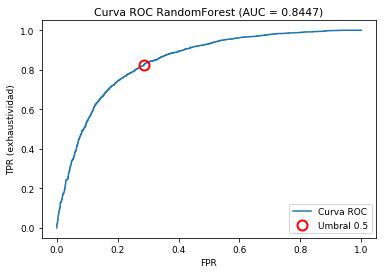

In [0]:
y_pred_test2 = ml_2.predict_proba(X_test2)[:,1]
fpr, tpr, umbrales = metrics.roc_curve(y_test2, y_pred_test2)
auc_roc = metrics.roc_auc_score(y_test2, y_pred_test2)

plt.rcParams.update({'font.size': 9})
plt.plot(fpr, tpr, label= ("Curva ROC") )
plt.xlabel("FPR")
plt.ylabel("TPR (exhaustividad)")
plt.title(("Curva ROC RandomForest (AUC = %.4f)" % auc_roc))
# ubicamos el punto más cercano a 0.5
umbral_05 = np.argmin(np.abs(umbrales - 0.5))
plt.plot(fpr[umbral_05], tpr[umbral_05], 'o', markersize=10,
         label="Umbral 0.5", fillstyle="none", c='r', mew=2)
plt.legend(loc=4, numpoints=1)

### AdaBoost

Aplicamos AdaBoost para el conjunto de datos 1

In [0]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

n_estimators=200
min_samples_leaf_grid = np.linspace(1,10,10).astype(int) 

In [0]:
mejor_score = 0
mejor_min_samples_leaf = None

for min_samples_leaf in min_samples_leaf_grid: 
    base_estimator = DecisionTreeClassifier(min_samples_leaf=min_samples_leaf, random_state=0)
    modelo_ab = AdaBoostClassifier(base_estimator=base_estimator, n_estimators=n_estimators, random_state=0)
    modelo_ab.fit(X_train1, y_train1)
    
    score_val = modelo_ab.score(X_val1, y_val1)
    
    if score_val > mejor_score: 
        mejor_score = score_val
        mejor_min_samples_leaf = min_samples_leaf
        mejor_modelo_ab = modelo_ab

modelo_ab = mejor_modelo_ab
modelo_ab.fit(X_train1, y_train1)

print ("Mejor valor de min_samples_leaf :", mejor_min_samples_leaf)
print ("Exactitud de AdaBoost en conjunto de entrenamiento :", modelo_ab.score(X_train1, y_train1))
print ("Exactitud de AdaBoost en conjunto de validación    :", mejor_score)

Mejor valor de min_samples_leaf : 8
Exactitud de AdaBoost en conjunto de entrenamiento : 0.9928792606961697
Exactitud de AdaBoost en conjunto de validación    : 0.9779332032097159


Aplicamos AdaBoost para el conjunto de datos 2

In [0]:
mejor_score = 0
mejor_min_samples_leaf = None

for min_samples_leaf in min_samples_leaf_grid: 
    base_estimator = DecisionTreeClassifier(min_samples_leaf=min_samples_leaf, random_state=0)
    modelo_ab = AdaBoostClassifier(base_estimator=base_estimator, n_estimators=n_estimators, random_state=0)
    modelo_ab.fit(X_train2, y_train2)
    
    score_val = modelo_ab.score(X_val2, y_val2)
    
    if score_val > mejor_score: 
        mejor_score = score_val
        mejor_min_samples_leaf = min_samples_leaf
        mejor_modelo_ab = modelo_ab

modelo_ab = mejor_modelo_ab
modelo_ab.fit(X_train2, y_train2)

print ("Mejor valor de min_samples_leaf :", mejor_min_samples_leaf)
print ("Exactitud de AdaBoost en conjunto de entrenamiento :", modelo_ab.score(X_train2, y_train2))
print ("Exactitud de AdaBoost en conjunto de validación    :", mejor_score)

Mejor valor de min_samples_leaf : 1
Exactitud de AdaBoost en conjunto de entrenamiento : 0.9951639537626799
Exactitud de AdaBoost en conjunto de validación    : 0.8738499646142959


### Redes Neuronales

In [0]:
#Referencia: http://scikit-learn.org/stable/modules/neural_networks_supervised.html
from sklearn.neural_network import MLPClassifier

In [0]:
#Referencia: https://www.kdnuggets.com/2016/10/beginners-guide-neural-networks-python-scikit-learn.html/2
from sklearn.metrics import classification_report, confusion_matrix

Ejecutamos el clasificador con los siguientes parametros:

In [0]:
#Primera prueba de alphas, con los valores superiores a 1 no se tienen buenos resultados.
#alphas = [0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100]
alphas = [0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.1, 1]

In [0]:
capas = [(10,), (20,), (50,), (100,), 
         (100, 10), (100, 20), (100, 50),
         (100, 50, 20), (100, 50, 10), (100, 20, 10),
         (100, 50, 20, 10)]

In [0]:
#Variables para capturar el mejor score para el conjunto de datos 1
score = 0
mejor_score = 0
mejor_alpha = 0
mejor_capa = None
mejor_clf = None

for alpha in alphas:
    for capa in capas:
        clf = MLPClassifier(activation='logistic', alpha=alpha, hidden_layer_sizes=capa, max_iter=1000)
        clf.fit(X_train1, y_train1) 
        score = clf.score(X_val1, y_val1)
        print('activation    : logistic')
        print('num. iteration: 1000')
        print('capas         :', capa)
        print('alpha         :', alpha)
        print('score         :', score)
        print('')
        if(mejor_score<score):
            mejor_score = score
            mejor_alpha = alpha
            mejor_capa = capa
            mejor_clf = clf

activation    : logistic
num. iteration: 1000
capas         : (10,)
alpha         : 1e-06
score         : 0.7755729053712138

activation    : logistic
num. iteration: 1000
capas         : (20,)
alpha         : 1e-06
score         : 0.7707655606159185

activation    : logistic
num. iteration: 1000
capas         : (50,)
alpha         : 1e-06
score         : 0.7806694137208126

activation    : logistic
num. iteration: 1000
capas         : (100,)
alpha         : 1e-06
score         : 0.7869587218969132

activation    : logistic
num. iteration: 1000
capas         : (100, 10)
alpha         : 1e-06
score         : 0.7898684305645919

activation    : logistic
num. iteration: 1000
capas         : (100, 20)
alpha         : 1e-06
score         : 0.7897599942167282

activation    : logistic
num. iteration: 1000
capas         : (100, 50)
alpha         : 1e-06
score         : 0.7846273404178414

activation    : logistic
num. iteration: 1000
capas         : (100, 50, 20)
alpha         : 1e-06
score  

score         : 0.7688679245283019

activation    : logistic
num. iteration: 1000
capas         : (100, 20, 10)
alpha         : 0.1
score         : 0.7462047278247669

activation    : logistic
num. iteration: 1000
capas         : (100, 50, 20, 10)
alpha         : 0.1
score         : 0.7686329791079303

activation    : logistic
num. iteration: 1000
capas         : (10,)
alpha         : 1
score         : 0.723975276512687

activation    : logistic
num. iteration: 1000
capas         : (20,)
alpha         : 1
score         : 0.7480300730138075

activation    : logistic
num. iteration: 1000
capas         : (50,)
alpha         : 1
score         : 0.7473613822019808

activation    : logistic
num. iteration: 1000
capas         : (100,)
alpha         : 1
score         : 0.7494939637099689

activation    : logistic
num. iteration: 1000
capas         : (100, 10)
alpha         : 1
score         : 0.7388129834453843

activation    : logistic
num. iteration: 1000
capas         : (100, 20)
alpha     

In [0]:
mejor_clf = MLPClassifier(activation='logistic', alpha=0.001, hidden_layer_sizes=(100, 50, 10), max_iter=1000)
mejor_clf.fit(X_train1, y_train1) 
mejor_score = mejor_clf.score(X_val1, y_val1)

In [0]:
#Revisamos el score para el conjunto de datos de prueba
print('Conjunto de datos 1')
print('===================')
print('Score validación:', mejor_score)
print('Score prueba    :', mejor_clf.score(X_test1, y_test1))

Conjunto de datos 1
Score validación: 0.793735993638401
Score prueba    : 0.7736210511096653


In [0]:
predicciones_val1 = mejor_clf.predict(X_test1)
accuracy_val1 =metrics.accuracy_score(y_test1, predicciones_val1) 
precision_val1 = metrics.precision_score(y_test1, predicciones_val1) 
recall_val1 = metrics.recall_score(y_test1, predicciones_val1)      
f1_test = metrics.f1_score(y_test1, predicciones_val1) 

print('Exactitud en el conjunto de validación     : {:.4f}'.format(accuracy_val1))
print('Precisión en el conjunto de validación     : {:.4f}'.format(precision_val1))
print('Exhaustividad en el conjunto de validación : {:.4f}'.format(recall_val1))
print('Puntaje F1 en el conjunto de prueba    : {:.4f}'.format(f1_test))

Exactitud en el conjunto de validación     : 0.7769
Precisión en el conjunto de validación     : 0.8250
Exhaustividad en el conjunto de validación : 0.7012
Puntaje F1 en el conjunto de prueba    : 0.7581


In [0]:
#Inicializamos nuevamente las variables para capturar el mejor score para el conjunto de datos 2
score = 0
mejor_score = 0
mejor_alpha = 0
mejor_capa = None
mejor_clf = None
for alpha in alphas:
    for capa in capas:
        clf = MLPClassifier(activation='logistic', alpha=alpha, hidden_layer_sizes=capa, max_iter=1000)
        clf.fit(X_train2, y_train2) 
        score = clf.score(X_val2, y_val2)
        print('activation    : logistic')
        print('num. iteration: 1000')
        print('capas         :', capa)
        print('alpha         :', alpha)
        print('score         :', score)
        print('')
        if(mejor_score<score):
            mejor_score = score
            mejor_alpha = alpha
            mejor_capa = capa
            mejor_clf = clf

activation    : logistic
num. iteration: 1000
capas         : (10,)
alpha         : 1e-06
score         : 0.7489384288747346

activation    : logistic
num. iteration: 1000
capas         : (20,)
alpha         : 1e-06
score         : 0.7549539985845718

activation    : logistic
num. iteration: 1000
capas         : (50,)
alpha         : 1e-06
score         : 0.7662774239207361

activation    : logistic
num. iteration: 1000
capas         : (100,)
alpha         : 1e-06
score         : 0.751238499646143

activation    : logistic
num. iteration: 1000
capas         : (100, 10)
alpha         : 1e-06
score         : 0.7604387827317763

activation    : logistic
num. iteration: 1000
capas         : (100, 20)
alpha         : 1e-06
score         : 0.7346072186836518

activation    : logistic
num. iteration: 1000
capas         : (100, 50)
alpha         : 1e-06
score         : 0.7622080679405521

activation    : logistic
num. iteration: 1000
capas         : (100, 50, 20)
alpha         : 1e-06
score   

activation    : logistic
num. iteration: 1000
capas         : (100, 20, 10)
alpha         : 0.1
score         : 0.7609695682944091

activation    : logistic
num. iteration: 1000
capas         : (100, 50, 20, 10)
alpha         : 0.1
score         : 0.7576079263977353

activation    : logistic
num. iteration: 1000
capas         : (10,)
alpha         : 1
score         : 0.7147912243453645

activation    : logistic
num. iteration: 1000
capas         : (20,)
alpha         : 1
score         : 0.7114295824486907

activation    : logistic
num. iteration: 1000
capas         : (50,)
alpha         : 1
score         : 0.7225760792639774

activation    : logistic
num. iteration: 1000
capas         : (100,)
alpha         : 1
score         : 0.7238145789101204

activation    : logistic
num. iteration: 1000
capas         : (100, 10)
alpha         : 1
score         : 0.6017338995046001

activation    : logistic
num. iteration: 1000
capas         : (100, 20)
alpha         : 1
score         : 0.594833687

In [0]:
#Revisamos el score para el conjunto de datos 2 de prueba
print('Conjunto de datos 2')
print('===================')
print('Score validación:', mejor_score)
print('Score prueba    :', mejor_clf.score(X_test2, y_test2))

Conjunto de datos 2
Score validación: 0.7692852087756546
Score prueba    : 0.7622080679405521


In [0]:
predicciones_val2 = mejor_clf.predict(X_test2)
accuracy_val2 =metrics.accuracy_score(y_test2, predicciones_val2) 
precision_val2 = metrics.precision_score(y_test2, predicciones_val2) 
recall_val2 = metrics.recall_score(y_test2, predicciones_val2)      
f1_test = metrics.f1_score(y_test2, predicciones_val2) 

print('Exactitud en el conjunto de validación     : {:.4f}'.format(accuracy_val2))
print('Precisión en el conjunto de validación     : {:.4f}'.format(precision_val2))
print('Exhaustividad en el conjunto de validación : {:.4f}'.format(recall_val2))
print('Puntaje F1 en el conjunto de prueba    : {:.4f}'.format(f1_test))

Exactitud en el conjunto de validación     : 0.7622
Precisión en el conjunto de validación     : 0.7872
Exhaustividad en el conjunto de validación : 0.7321
Puntaje F1 en el conjunto de prueba    : 0.7586


Se realizaron las mismas pruebas con el modelo MLPRegressor, pero se obtuvo un score muy bajo. Por ello no se considera en el notebook todas las pruebas, solo un ejemplo de ellas.

In [0]:
from sklearn.neural_network import MLPRegressor

In [0]:
clf2 = MLPRegressor(activation='logistic', max_iter=1000)

In [0]:
clf2.fit(X_train1, y_train1) 

In [0]:
clf2.score(X_test1, y_test1) 